# Set Up the Environment

### Importing Libraries

In [ ]:

%pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torchvision
from torchvision import transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure
from transformers import AutoModelForDepthEstimation
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
# from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet101_Weights

import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

### Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


# Define Needed Classes & Functions

### Class for Depth Model

In [ ]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        predicted_depth = F.interpolate(predicted_depth.unsqueeze(1), size=(384, 384), mode='bilinear', align_corners=False)
        return predicted_depth

### Class for Student Model

In [ ]:

class StudentModel(nn.Module):
    """
    Student model with MobileNetV3 encoder and a custom decoder.
    Designed for real-time inference on edge devices.
    """
    def __init__(self, output_channels=1):
        super(StudentModel, self).__init__()
        # Load MobileNetV3 Large features as the encoder
        self.encoder = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).features
        
        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # --- Enhancement: 1x1 Convolutions for Skip Connections ---
        # These layers refine the features from the encoder before fusion.
        # Channel dimensions correspond to MobileNetV3 skip connection outputs.
        self.skip_s4_conv = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )
        self.skip_s8_conv = nn.Sequential(
            nn.Conv2d(40, 40, kernel_size=1, bias=False),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True)
        )
        self.skip_s16_conv = nn.Sequential(
            nn.Conv2d(80, 80, kernel_size=1, bias=False),
            nn.BatchNorm2d(80),
            nn.ReLU(inplace=True)
        )
        self.skip_s32_conv = nn.Sequential(
            nn.Conv2d(112, 112, kernel_size=1, bias=False),
            nn.BatchNorm2d(112),
            nn.ReLU(inplace=True)
        )

        # Decoder blocks (input channels remain the same as the 1x1 convs don't change channel dims)
        self.decoder_block1 = nn.Sequential(
            nn.Conv2d(960 + 112, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        )
        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(512 + 80, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        )
        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256 + 40, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        )
        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(128 + 24, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        )

        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        self.final_activation = nn.ReLU()

    def forward(self, x):
        input_shape = x.shape[2:] 
        skip_features = {}
        
        # --- Encoder Path & Feature Extraction ---
        # Iterate through encoder layers to get skip connections
        # Apply 1x1 convs immediately after extraction.
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i == 2:  # s4 (H/4, W/4 resolution, 24 channels)
                skip_features['s4'] = self.skip_s4_conv(x)
            elif i == 4:  # s8 (H/8, W/8 resolution, 40 channels)
                skip_features['s8'] = self.skip_s8_conv(x)
            elif i == 7:  # s16 (H/16, W/16 resolution, 80 channels)
                skip_features['s16'] = self.skip_s16_conv(x)
            elif i == 11:  # s32 (H/16, W/16 resolution, 112 channels)
                skip_features['s32'] = self.skip_s32_conv(x)

        # Ensure s32 matches the spatial dimension of the encoder's final output
        if skip_features['s32'].shape[2:] != x.shape[2:]:
            skip_features['s32'] = F.interpolate(skip_features['s32'], size=x.shape[2:], mode='bilinear', align_corners=False)

        # --- Decoder Path with Enhanced Skip Connections ---
        # Concatenate final encoder output (x) with the refined s32 skip connection
        x = torch.cat([x, skip_features['s32']], dim=1)
        x = self.decoder_block1(x)

        # Concatenate with refined s16
        x = torch.cat([x, skip_features['s16']], dim=1)
        x = self.decoder_block2(x)

        # Concatenate with refined s8
        x = torch.cat([x, skip_features['s8']], dim=1)
        x = self.decoder_block3(x)

        # Concatenate with refined s4
        x = torch.cat([x, skip_features['s4']], dim=1)
        x = self.decoder_block4(x)

        # Final layers
        x = self.final_conv(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = self.final_activation(x)
        
        return x

### Class for Dataset Loading & Preprocessing

In [ ]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

### Distillation Loss

In [ ]:
class DepthDistillationLoss(nn.Module):
    """
    Custom loss function for depth distillation.
    Using Pixel wise MSE Loss, SSIM, Gradient MAE Loss, and Scale-Invariant MSE Loss.
    """
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, lambda_smooth=0.2, window_size=11):
        super().__init__()
        self.lambda_depth = lambda_depth   # Weight for depth map MSE loss
        self.lambda_si = lambda_si         # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad     # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim     # Weight for SSIM loss
        self.lambda_smooth = lambda_smooth # Weight for smoothness regularizer

        self.mse_depth_loss = nn.MSELoss()  # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss()          # L1 Loss for gradients

        # Initialize the SSIM calculation from torchmetrics
        if self.lambda_ssim > 0:
            self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=window_size)

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)

        # Ensure tensors have a channel dimension for SSIM
        if student_depth.dim() == 3: # Assuming (Batch, Height, Width)
            student_depth = student_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)
        if teacher_depth.dim() == 3: # Assuming (Batch, Height, Width)
            teacher_depth = teacher_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)


        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
            diff = student_depth - teacher_depth
            loss_si = torch.mean(diff**2) - torch.mean(diff)**2
            total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4.Smoothness Loss (Regularizer)
        if self.lambda_smooth > 0:
            # Penalizes the L1 norm of the student's depth gradients
            loss_smooth = torch.mean(student_grad_x) + torch.mean(student_grad_y)
            total_loss += self.lambda_smooth * loss_smooth

        # 5. SSIM Loss
        if self.lambda_ssim > 0:
            # Move ssim module to the same device as the tensors
            self.ssim.to(student_depth.device)

            # The torchmetrics SSIM implementation returns a value between -1 and 1.
            # A value of 1 indicates perfect similarity.
            # To use it as a loss, we subtract it from 1.
            d_ssim = self.ssim(student_depth, teacher_depth)
            loss_ssim = (1 - d_ssim) / 2 # Normalize to be between 0 and 1
            total_loss += self.lambda_ssim * loss_ssim

        return total_loss

### The Training Function

In [ ]:
def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    x = 0
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()
        for batch_idx, inputs in enumerate(dataloader):
            # if batch_idx == 16:
            #   break
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")
        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%10 == 0:
          models.append(student)
          torch.save(student.state_dict(), f"/content/drive/MyDrive/student_epoch_{epoch+1}.pth")
          print(f"Student model saved to /content/drive/MyDrive/student_epoch_{epoch+1}.pth")

    print("Knowledge Distillation Training Finished!")
    return models

# Training Process

### Define Parameters & Models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)


teacher_model = DepthModel(teacher).to(device)

# student  model architecture
student_model = StudentModel().to(device)
######################################################
# Load the entire model object from the checkpoint
student_model = torch.load('/content/drive/MyDrive/distillSkip1700.pth', weights_only=False).to(device)

###########################
# Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 40

# Distillation Loss
# Instantiate the custom loss function
distillation_criterion = DepthDistillationLoss(lambda_depth=0.5,  lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, window_size=11)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

eval_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=5, shuffle=True, num_workers=2)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 62.2MB/s]


Found 152 images in /content/drive/MyDrive/images/


Before Training

In [ ]:
# Load train image
image_path = "/content/drive/MyDrive/images/image1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [ ]:
# --- Verify which layers are trainable ---
print("All parameters in student_model:")
for name, param in student_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

# print("----------------------------------------")
# for name, param in student_model.named_parameters():
#     param.requires_grad = False

# # Unfreeze parameters in the 'head' layer
# for name, param in student_model.decoder.named_parameters():
#     param.requires_grad = True

# # --- Verify which layers are trainable ---
# print("Trainable parameters in student_model:")
# for name, param in student_model.named_parameters():
#     if param.requires_grad:
#         print(f"  {name}")


All parameters in student_model:
  decoder_block1.0.weight
  decoder_block1.0.bias
  decoder_block2.0.weight
  decoder_block2.0.bias
  decoder_block3.0.weight
  decoder_block3.0.bias
  decoder_block4.0.weight
  decoder_block4.0.bias
  final_conv.weight
  final_conv.bias


### Run the Training

In [ ]:
    # Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...
Epoch 1 finished. Avg Loss: 2720.9381, Time: 224.58s
Epoch 2 finished. Avg Loss: 2653.7121, Time: 224.85s
Epoch 3 finished. Avg Loss: 2517.2932, Time: 225.69s
Epoch 4 finished. Avg Loss: 2816.5874, Time: 220.84s
Epoch 5 finished. Avg Loss: 2548.3351, Time: 228.70s
Epoch 6 finished. Avg Loss: 3001.3841, Time: 224.71s
Epoch 7 finished. Avg Loss: 2731.8762, Time: 218.60s
Epoch 8 finished. Avg Loss: 2756.1660, Time: 230.28s
Epoch 9 finished. Avg Loss: 3137.0520, Time: 224.82s
Epoch 10 finished. Avg Loss: 2865.7530, Time: 224.20s
Student model saved to /content/drive/MyDrive/student_epoch_10.pth


Starting Knowledge Distillation Training on cuda...

Epoch 1 finished. Avg Loss: 4499.8968, Time: 248.31s

Epoch 2 finished. Avg Loss: 4149.1156, Time: 228.33s

Epoch 3 finished. Avg Loss: 3886.1978, Time: 216.81s

Epoch 4 finished. Avg Loss: 3842.8344, Time: 220.17s

Epoch 5 finished. Avg Loss: 3781.1853, Time: 248.04s

Epoch 6 finished. Avg Loss: 3436.8746, Time: 220.75s

Epoch 7 finished. Avg Loss: 4241.4262, Time: 230.12s

Epoch 8 finished. Avg Loss: 4201.5310, Time: 224.50s

Epoch 9 finished. Avg Loss: 3510.6774, Time: 221.85s

Epoch 10 finished. Avg Loss: 3359.3179, Time: 221.52s

Student model saved to /content/drive/MyDrive/student_epoch_10.pth

Epoch 11 finished. Avg Loss: 3566.9869, Time: 222.47s

Epoch 12 finished. Avg Loss: 3535.3948, Time: 229.01s

Epoch 13 finished. Avg Loss: 3455.8518, Time: 216.41s

Epoch 14 finished. Avg Loss: 3484.5944, Time: 221.07s

Epoch 15 finished. Avg Loss: 3627.4576, Time: 224.77s

Epoch 16 finished. Avg Loss: 3485.8576, Time: 216.55s

Epoch 17 finished. Avg Loss: 3572.9871, Time: 222.93s

Epoch 18 finished. Avg Loss: 3307.2524, Time: 215.53s

Epoch 19 finished. Avg Loss: 3272.6310, Time: 218.64s

Epoch 20 finished. Avg Loss: 3149.6892, Time: 218.25s

Student model saved to /content/drive/MyDrive/student_epoch_20.pth

Epoch 21 finished. Avg Loss: 3626.3751, Time: 220.03s

Epoch 22 finished. Avg Loss: 3193.6049, Time: 225.47s

Epoch 23 finished. Avg Loss: 3255.4719, Time: 222.69s

Epoch 24 finished. Avg Loss: 3636.9332, Time: 214.89s


Epoch 25 finished. Avg Loss: 3250.9417, Time: 217.53s

Epoch 26 finished. Avg Loss: 3312.0016, Time: 222.81s

Epoch 27 finished. Avg Loss: 3395.3886, Time: 217.16s

Epoch 28 finished. Avg Loss: 3017.2792, Time: 231.39s

Epoch 29 finished. Avg Loss: 2872.4931, Time: 217.17s

Epoch 30 finished. Avg Loss: 2849.7717, Time: 219.24s

Student model saved to /content/drive/MyDrive/student_epoch_30.pth

# Evaluation

### On training

✅ Student model inference time: 8.83 ms


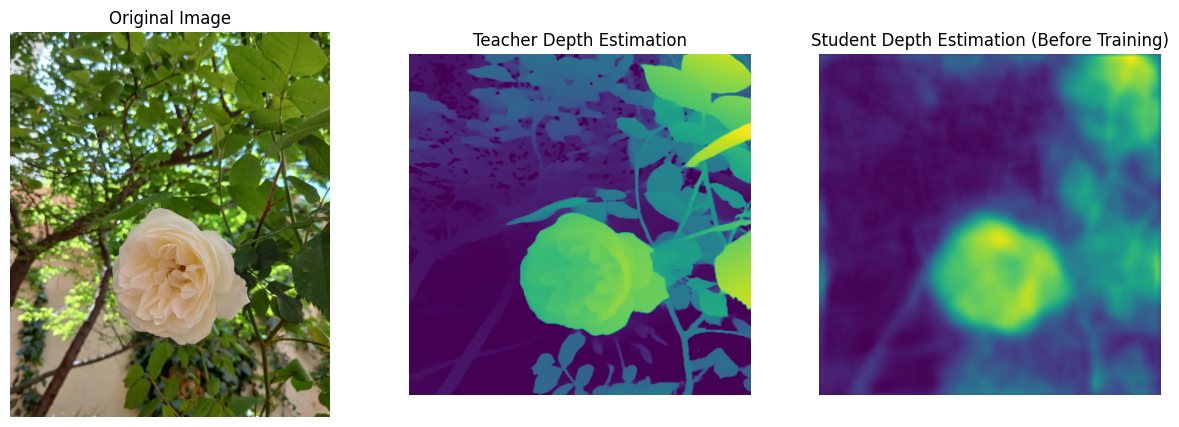

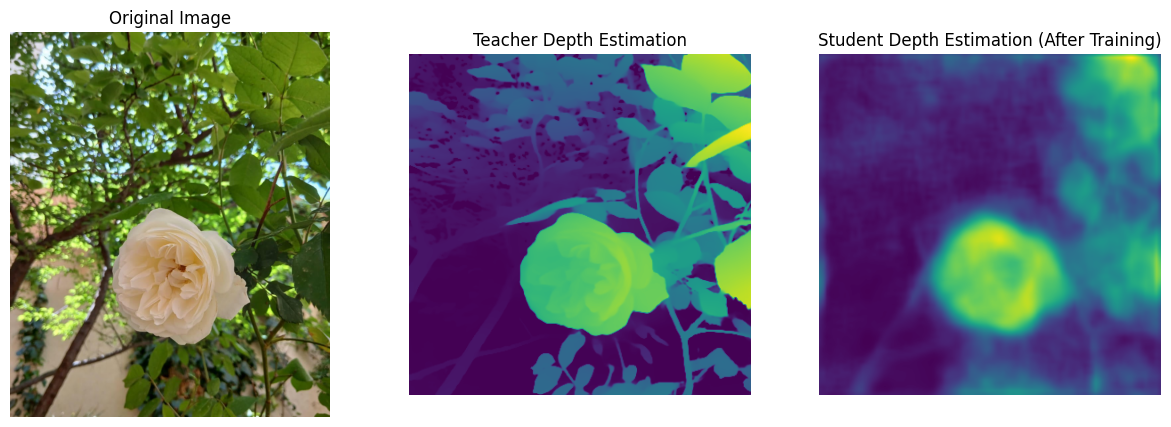

In [ ]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



### On Testing

5336.51416015625


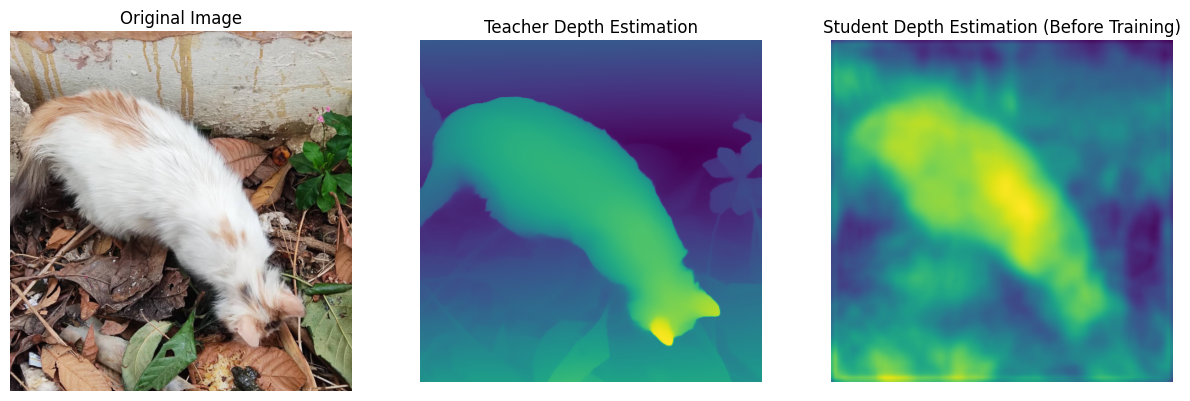

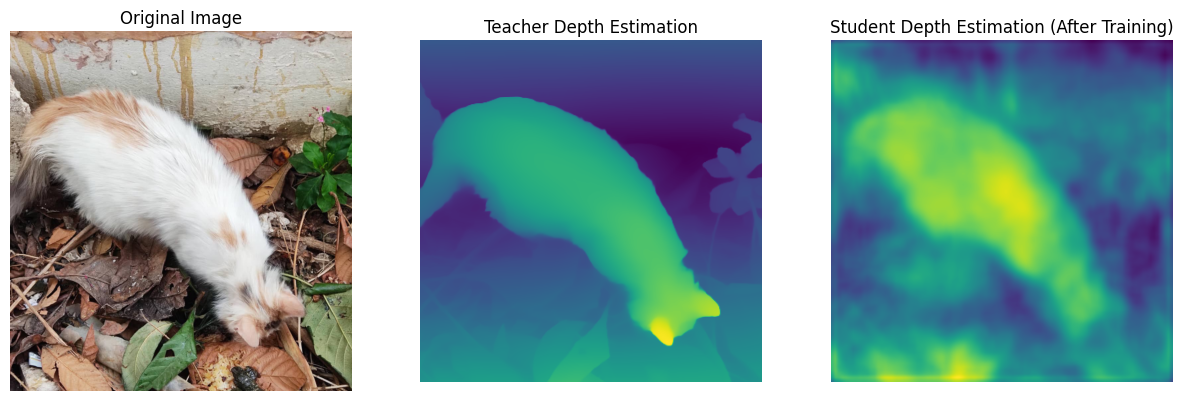

In [ ]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

### Saving a CheckPoint

In [ ]:
torch.save(student_model, "/content/drive/MyDrive/distillSkipL2500.pth")